## ÉTUDE DU TEMPS D’ATAQUE ET DÉFENSE 


L’objectif des graphiques suivantes est d'analyzer le temps que les joueurs de chaque équipe passent dans son côte du terrain et le temps qu'ils passent dans l’autre côte. 
On peut dire que si les joueurs sont dans son côte il sont en train de défendre. En revanche, s’ils sont de l’autre côte c’est car ils sont en train de attaquer.
Pendant le temp qu’une équipe attaque, la probabilité de marquer un but est évidement plus haute et en conséquence la dangerosité augmente.

C'est intéressant de faire le rapport avec le numéro de buts pour confirmer si effectivement l’équipe  attaquant est l’équipe qui a marqué plus de buts.

Ce notebook utilise les fichiers des deux matches qui sont gardés dans le path suivant : Dataset > sample-data-master > data > Sample_Game_1 et Sample_Game_2.

Pour changer de match il est simplement nécessaire de changer le game_id

In [29]:
import pandas as pd
import csv as csv
import numpy as np
import matplotlib.pyplot as plt

Tout d’abord on a importé les libraires nécessaires et par la suite on va créer les fonctions pour charger les datasets et pour faire les premières transformations et calculs 

In [3]:
# Télécharger le fichier avec les events:

def read_event_data(DATADIR,game_id):

    eventfile = '/Sample_Game_%d/Sample_Game_%d_RawEventsData.csv' % (game_id,game_id) # filename
    events = pd.read_csv('{}/{}'.format(DATADIR, eventfile)) # read data
    return events

# Télécharger les fichiers tracking:

def tracking_data(DATADIR,game_id,teamname):

    teamfile = '/Sample_Game_%d/Sample_Game_%d_RawTrackingData_%s_Team.csv' % (game_id,game_id,teamname)
    # First:  deal with file headers so that we can get the player names correct
    csvfile =  open('{}/{}'.format(DATADIR, teamfile), 'r') # create a csv file reader
    reader = csv.reader(csvfile) 
    teamnamefull = next(reader)[3].lower()
    print("Reading team: %s" % teamnamefull)
    # construct column names
    jerseys = [x for x in next(reader) if x != ''] # extract player jersey numbers from second row
    columns = next(reader)
    for i, j in enumerate(jerseys): # create x & y position column headers for each player
        columns[i*2+3] = "{}_{}_x".format(teamname, j)
        columns[i*2+4] = "{}_{}_y".format(teamname, j)
    columns[-2] = "ball_x" # column headers for the x & y positions of the ball
    columns[-1] = "ball_y"
    # Second: read in tracking data and place into pandas Dataframe
    tracking = pd.read_csv('{}/{}'.format(DATADIR, teamfile), names=columns, index_col='Frame', skiprows=3)
    return tracking

# Fonction qui permet transformer les positions à mètres:

def to_metric_coordinates(data,field_dimen=(106.,68.) ):

    x_columns = [c for c in data.columns if c[-1].lower()=='x']
    y_columns = [c for c in data.columns if c[-1].lower()=='y']
    data[x_columns] = ( data[x_columns]-0.5 ) * field_dimen[0]
    data[y_columns] = -1 * ( data[y_columns]-0.5 ) * field_dimen[1]

    return data

# On a besoin de savoir de quel côte se trouve le gardian pour savoir si l'équipe est de son côté sur le terrain.

def find_goalkeeper(df):
    x_columns = [c for c in df.columns if c[-2:].lower()=='_x' and c[:4] in ['Home','Away']]
    GK_col = df.iloc[0][x_columns].abs().idxmax(axis=1)
    n_golkeep = int(GK_col.split('_')[1])

    if x_columns[0][:4] == 'Away':
        prim_e = [e for e in df['Away_%d_x' %(n_golkeep)]]
        if prim_e[0] > 0:
            return "Gardian côté droit"
        else:
            return "Gardian côté gauche"
    else:
        prim_e = [e for e in df['Home_%d_x' %(n_golkeep)]]
        if prim_e[0] > 0:
            return "Gardian côté droit"
        else:
            return "Gardian côté gauche"
        
# On va comptabiliser en minutes le temps que les joueurs sont d’un côté et de l’autre

def temps_cote_droit(df):
    x_columns = [c for c in df.columns if c[-2:].lower()=='_x' and c[:4] in ['Home','Away']]
    conteur = 0
    time=[]
    for i in x_columns:
        for e in df[i]:
            if e > 0:
                conteur += 1
        time.append((conteur*0.04)/60)
        conteur = 0
    return time
def temps_cote_gauche(df):
    x_columns = [c for c in df.columns if c[-2:].lower()=='_x' and c[:4] in ['Home','Away']]
    conteur = 0
    time=[]
    for i in x_columns:
        for e in df[i]:
            if e < 0:
                conteur += 1
        time.append((conteur*0.04)/60)
        conteur = 0
    return time

In [21]:
DATADIR = 'C:/Users/crist'
game_id = 1

events = read_event_data(DATADIR,game_id)
tracking_home = tracking_data(DATADIR,game_id,'Home')
tracking_away = tracking_data(DATADIR,game_id,'Away')

Reading team: home
Reading team: away


In [22]:
tracking_home = to_metric_coordinates(tracking_home)
tracking_away = to_metric_coordinates(tracking_away)

# On sépare le match en première et deuxième partie

prem_partie_away = tracking_away[tracking_away['Period']==1]
deux_partie_away = tracking_away[tracking_away['Period']==2]
prem_partie_home = tracking_home[tracking_home['Period']==1]
deux_partie_home = tracking_home[tracking_home['Period']==2]

In [23]:
def ataq_def(dfhome, dfaway):
    cote_home = find_goalkeeper(dfhome)
    global ataque_home
    global ataque_away
    global defense_home
    global defense_away
    if cote_home == 'Gardian côté gauche':
        ataque_home = np.sum(temps_cote_droit(dfhome))
        ataque_away = np.sum(temps_cote_gauche(dfaway))
        defense_home = np.sum(temps_cote_gauche(dfhome))
        defense_away = np.sum(temps_cote_droit(dfaway))
    else:
        ataque_home = np.sum(temps_cote_gauche(dfhome))
        ataque_away = np.sum(temps_cote_droit(dfaway))
        defense_home = np.sum(temps_cote_droit(dfhome))
        defense_away = np.sum(temps_cote_gauche(dfaway))
    return [ataque_home, ataque_away, defense_home, defense_away]

In [24]:
home_events = events[events['Team']=='Home']
away_events = events[events['Team']=='Away']
shots = events[events['Type']=='SHOT']
home_shots = home_events[home_events.Type=='SHOT']
away_shots = away_events[away_events.Type=='SHOT']
home_goals = home_shots[home_shots['Subtype'].str.contains('-GOAL')].copy()
away_goals = away_shots[away_shots['Subtype'].str.contains('-GOAL')].copy()

In [25]:
goals_home_prem = home_goals[home_goals['Period']==1]['Period']
goals_home_deux = home_goals[home_goals['Period']==2]['Period']
goals_away_prem = away_goals[away_goals['Period']==1]['Period']
goals_away_deux = away_goals[away_goals['Period']==2]['Period']

In [26]:
if goals_home_prem.empty:
    goals_home_prem = 0
else:
    goals_home_prem = home_goals[home_goals['Period']==1]['Period'].value_counts()[1]
if goals_home_deux.empty:
    goals_home_deux = 0
else:
    goals_home_deux = home_goals[home_goals['Period']==2]['Period'].value_counts()[2]
if goals_away_prem.empty:
    goals_away_prem = 0
else:
    goals_away_prem = away_goals[away_goals['Period']==1]['Period'].value_counts()[1]
if goals_away_deux.empty:
    goals_away_deux = 0
else:
    goals_away_deux = away_goals[away_goals['Period']==2]['Period'].value_counts()[2]

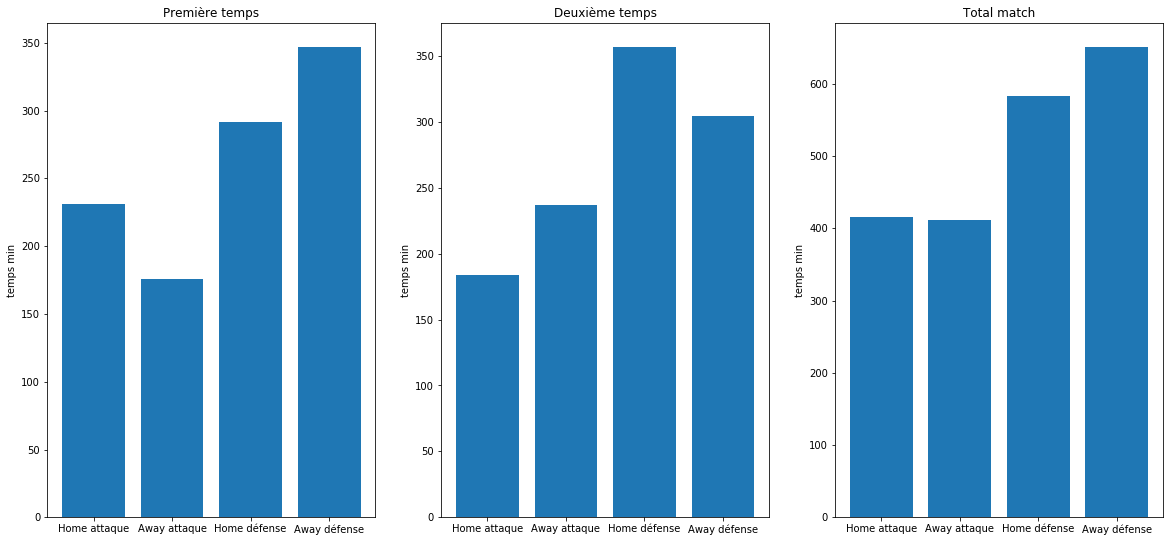

In [27]:
x =["Home attaque", "Away attaque", "Home défense", "Away défense"]

prem_temps = ataq_def(prem_partie_home, prem_partie_away)
deux_temps = ataq_def(deux_partie_home, deux_partie_away)
total = [prem_temps[0] + deux_temps[0], prem_temps[1]+deux_temps[1], prem_temps[2]+prem_temps[2], prem_temps[3]+deux_temps[3]] 
fig = plt.figure(figsize=(20,20))
plt.subplot(2,3,1)
plt.bar(x, prem_temps)
plt.ylabel('temps min')
plt.title('Première temps')
plt.subplot(2,3,2)
plt.bar(x, deux_temps)
plt.ylabel('temps min')
plt.title('Deuxième temps')
plt.subplot(2,3,3)
plt.bar(x, total)
plt.ylabel('temps min')
plt.title('Total match');



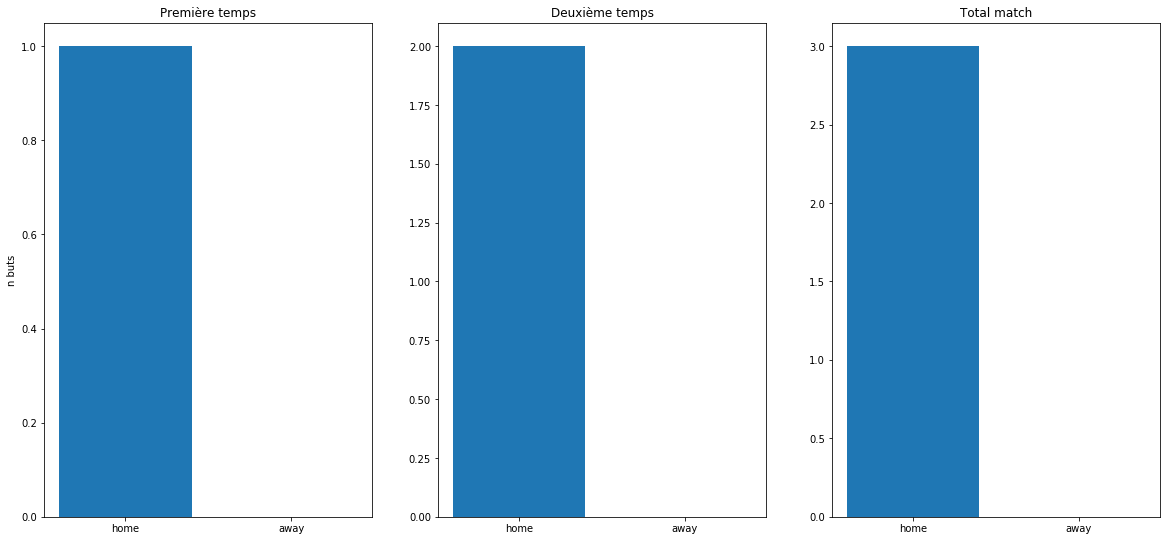

In [28]:
fig = plt.figure(figsize=(20,20))
plt.subplot(2,3,1)
plt.bar(['home', 'away'], [goals_home_prem, goals_away_prem])
plt.ylabel('n buts')
plt.title('Première temps')
plt.subplot(2,3,2)
plt.bar(['home', 'away'], [goals_home_deux, goals_away_deux])
plt.title('Deuxième temps')
plt.subplot(2,3,3)
plt.bar(['home', 'away'], [(goals_home_prem+goals_home_deux), (goals_away_prem+goals_away_deux)])
plt.title('Total match');


On peut voir dans le deux match que l'équipe qui a attaqué a été l'équipe qui a marqué plus de buts